In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from  sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import GridSearchCV

# Выявление спама

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!pip install PyDrive

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
data = drive.CreateFile({'id':"14aKUK159J9M49WiNThyhpr39LxT7w0Wo"})
data.GetContentFile('SMSSpamCollection.txt')

In [ ]:
with open('SMSSpamCollection.txt', 'r') as file:
    data = file.read().splitlines()

In [ ]:
data[0:5]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though"]

## Список меток и список текстов

In [ ]:
#разделяем на два списка: меток и текстов
labels, texts = zip(*[line.split('\t') for line in data])
#1 - спам, 0 - не спам
num_labels = np.array([0 if x=='ham' else 1 for x in labels])

In [ ]:
print(labels[0:5])
print(num_labels[0:5])
print(texts[0:5])

##Логистическая регрессия

Разобъем выборку на трейн и тест

In [ ]:
text_train, text_val, y_train, y_val = train_test_split(texts, num_labels,  random_state=0)

Обучим логистическую регрессию + в векторайзере отфильтруем слова общей лексики

In [ ]:
vect = CountVectorizer(stop_words='english')
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)

In [ ]:
lr = LogisticRegression().fit(X_train, y_train)
print(f"Качество на обучении {lr.score(X_train, y_train)}: и на валидации: {lr.score(X_val, y_val)}")

Качество на обучении 0.9956937799043062: и на валидации: 0.9770444763271162


In [ ]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

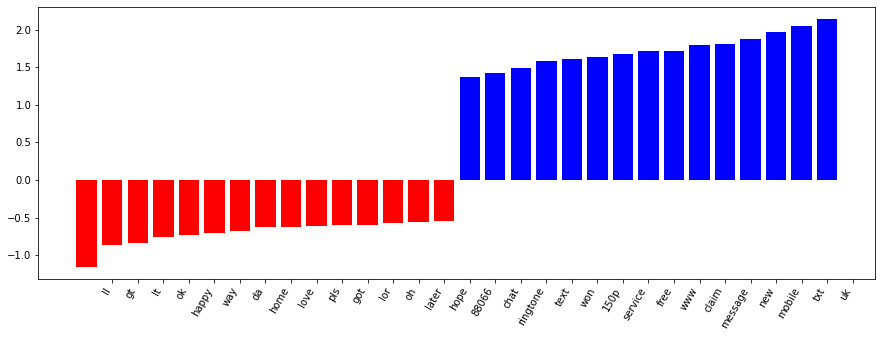

In [ ]:
visualize_coefficients(lr, vect.get_feature_names(), n_top_features=15)

## Пайплайны для выбора моделей

Cделаем пайплайн, в котором будем перебирать эстиматоры и гиперпараметры.

In [ ]:
pipe =  Pipeline([("vectorizer", CountVectorizer()),
                  ("transformer", TfidfTransformer()),
                  ("classifier", LogisticRegression())])

In [ ]:
param_grid = [{'vectorizer': [CountVectorizer(stop_words='english')], 
               'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 
               'vectorizer__analyzer': ['word', 'char', 'char_wb'],
               'transformer': [TfidfTransformer()], 
               'classifier': [LogisticRegression()],
               'classifier__C': np.logspace(0.01, 1, 5)},
              {'vectorizer': [CountVectorizer(stop_words='english')], 
               'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)], 
               'vectorizer__analyzer': ['word', 'char', 'char_wb'],
               'transformer': [TfidfTransformer()], 
               'classifier': [LinearSVC()],
               'classifier__C': np.logspace(0.01, 1, 5)},
              {'vectorizer': [CountVectorizer(stop_words='english')], 
               'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
               'vectorizer__analyzer': ['word', 'char', 'char_wb'],
               'transformer': [None], 
               'classifier': [MultinomialNB()],
               'classifier__alpha': np.linspace(0.01, 1, 5),
               }]

Кроссвалидация:

In [ ]:
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)

LinearSVC даёт лучший скор:

In [ ]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(text_val, y_val)))

Best params:
{'classifier': LinearSVC(C=3.198895109691398, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0), 'classifier__C': 3.198895109691398, 'transformer': TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), 'vectorizer': CountVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None), 'vectorizer__analyzer': 'char', 'vectorizer__ngram_range': (1, 2)}

Best cross-validation score: 0.99
Test-set score: 0.99


Визуализация с лучшими гиперпараметрами:

In [ ]:
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', analyzer='char')
X_train = vect.fit_transform(text_train)
X_val = vect.transform(text_val)
lrSVC = LinearSVC(C=3.198895109691398)
lrSVC.fit(X_train, y_train)
print(f"Качество на обучении {lrSVC.score(X_train, y_train)}: и на валидации: {lrSVC.score(X_val, y_val)}")

Качество на обучении 1.0: и на валидации: 0.9849354375896701


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


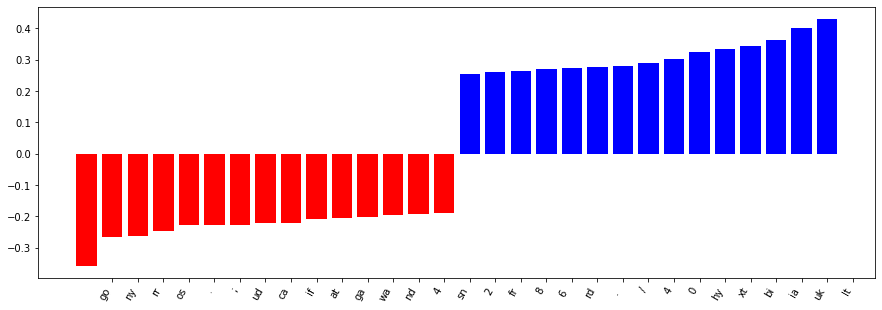

In [ ]:
visualize_coefficients(lrSVC, vect.get_feature_names(), n_top_features=15)